# Dataset importation
At first, we import the dataset in csv format and perform an essential exploration of its features.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [409]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold

In [2]:
data = pd.read_csv('CrowdstormingDataJuly1st.csv')
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


## Splitting in testing and train

Since some labels are missing we consider for the training dataset the players with both ratings.
Note that there are no players with a single rating missing.

In [3]:
final_test=data[data.rater2.isnull() & data.rater1.isnull()]
final_train=data[data.rater2.notnull() & data.rater1.notnull()]

In [4]:
final_train.shape

(124621, 28)

In [5]:
final_test.shape

(21407, 28)

In [6]:
data.shape

(146028, 28)

# Data analysis

### Preprocessing
 - Delete the column photoID
 - Delete all the rows corresponding to a referee with less than 22 entry (impossible - problem in the dataset)
 - Remove less significant referee entry (with nIAT and nExp too low)

In [547]:
def preprocess_1(database,remove_bad_referee=True,nIAT_threshold=50,nExp_threshold=50):
    train=database.copy()
    del train['photoID']
    
    train_group=train.groupby(train.refNum)
    
    if remove_bad_referee:
        for i,group in train_group:
            if group.shape[0]<22:
                train=train.drop(train_group.get_group(i).index)
            if i%500==0:
                print(i)
    
   
    return train

In [548]:
train_base=preprocess_1(final_train,remove_bad_referee=True)

500
1000
1500
2000
2500
3000


In [549]:
def preprocess_2(database,nIAT_threshold=50,nExp_threshold=50):
    train=database.copy()
    train_group=database.groupby(train.refNum)

    for i,group in train_group:
        if group.nIAT.iloc[0]<nIAT_threshold or group.nExp.iloc[0]<nExp_threshold:
            train=train.drop(train_group.get_group(i).index)
        if i%200==0:
            print(i)
    return train

In [550]:
train=preprocess_2(train_base)

1600
2400
3000


In [555]:
final_train.shape

(124621, 28)

In [553]:
train_base.shape

(112484, 27)

In [551]:
train.shape

(111533, 27)

In [559]:
train['IAT_yellow']=train.yellowCards*train.meanIAT
train['IAT_red']=train.redCards*train.meanIAT
train['Exp_yellow']=train.yellowCards*train.meanExp
train['Exp_red']=train.redCards*train.meanExp

In [558]:
train.head(10)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,IAT_yellow,IAT_red,Exp_yellow,Exp_red
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000000,0.0,0.000000,0.0
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000000,0.0,0.000000,0.0
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000000,0.0,0.000000,0.0
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000000,0.0,0.000000,0.0
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000000,0.0,0.000000,0.0
10,antonio-rukavina,Antonio Rukavina,Real Valladolid,Spain,26.01.1984,177.0,74.0,Right Fullback,2,2,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.325185,0.0,0.538462,0.0
11,ashkan-dejagah,Ashkan Dejagah,Fulham FC,England,05.07.1986,181.0,74.0,Left Winger,1,1,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000000,0.0,0.000000,0.0
12,benedikt-hoewedes,Benedikt Höwedes,FC Schalke 04,Germany,29.02.1988,187.0,80.0,Center Back,1,1,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000000,0.0,0.000000,0.0
13,chris-baird,Chris Baird,Fulham FC,England,25.02.1982,186.0,77.0,Defensive Midfielder,1,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000000,0.0,0.000000,0.0
14,chris-brunt,Chris Brunt,West Bromwich Albion,England,14.12.1984,185.0,74.0,NaN,1,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000000,0.0,0.000000,0.0


In [490]:
(train.nExp[train.nExp<100]).value_counts()

44.0    280
39.0    140
19.0     97
12.0     85
95.0     77
13.0     77
41.0     63
28.0     54
29.0     41
27.0     38
69.0     37
76.0     28
15.0     28
49.0     26
10.0     22
Name: nExp, dtype: int64

In [485]:
min(train.nExp)

10.0

# Random forest with referee information

In [578]:
train_ref=train[['playerShort','leagueCountry','birthday','height','weight','position','IAT_yellow','IAT_red','Exp_yellow','Exp_red']]

In [579]:
train_ref=train_ref.fillna(train_ref.median())

In [580]:
train_ref.position=train_ref.position.fillna('nan')

In [581]:
train_ref.leagueCountry=train_ref.leagueCountry.fillna('nan')

In [582]:
train_ref.birthday=train_ref.birthday.apply(lambda x: int(x.split('.')[2]))

In [583]:
a=pd.get_dummies(train_ref[['position','leagueCountry']])

In [584]:
train_ref=pd.concat([train_ref,a],axis=1)

In [585]:
del train_ref['leagueCountry']
del train_ref['position']

In [587]:
train_ref.groupby('playerShort').mean().head()

,birthday,height,weight,IAT_yellow,IAT_red,Exp_yellow,Exp_red,position_Attacking Midfielder,position_Center Back,position_Center Forward,...,position_Left Midfielder,position_Left Winger,position_Right Fullback,position_Right Midfielder,position_Right Winger,position_nan,leagueCountry_England,leagueCountry_France,leagueCountry_Germany,leagueCountry_Spain
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,1979,182.0,71.0,0.042801,0.000000,0.054873,0.000000,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
aaron-hunt,1986,183.0,73.0,0.142176,0.003581,0.162350,0.003574,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
aaron-lennon,1987,165.0,63.0,0.036889,0.000000,0.044686,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
aaron-ramsey,1990,178.0,76.0,0.108983,0.003486,0.138661,0.003501,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
abdelhamid-el-kaoutari,1990,180.0,73.0,0.076499,0.019125,0.076823,0.019206,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Random forest with only trivial information
No referee information used


### Preprocessing of dataset

In [426]:
train_trivial=train.groupby('playerShort').first()

In [427]:
train_trivial.birthday=train_trivial.birthday.apply(lambda x: int(x.split('.')[2]))

In [428]:
y_trivial=(train_trivial['rater1']+train_trivial['rater2'])/2

In [429]:
train_trivial=train_trivial[['leagueCountry','birthday','height','weight','position']]

In [430]:
train_trivial=train_trivial.fillna(train_trivial.median())

In [431]:
train_trivial.head(4)

,leagueCountry,birthday,height,weight,position
playerShort,,,,,
aaron-hughes,England,1979,182.0,71.0,Center Back
aaron-hunt,Germany,1986,183.0,73.0,Attacking Midfielder
aaron-lennon,England,1987,165.0,63.0,Right Midfielder
aaron-ramsey,England,1990,178.0,76.0,Center Midfielder


In [435]:
train_trivial.position=train_trivial.position.fillna('nan')

In [436]:
train_trivial.leagueCountry=train_trivial.leagueCountry.fillna('nan')

In [437]:
len(train_trivial)

1585

### Categorizing data

In [439]:
a=pd.get_dummies(train_trivial[['position','leagueCountry']])

In [440]:
train_trivial=pd.concat([train_trivial,a],axis=1)

In [442]:
del train_trivial['leagueCountry']
del train_trivial['position']
train_trivial.head(4)

,birthday,height,weight,position_Attacking Midfielder,position_Center Back,position_Center Forward,position_Center Midfielder,position_Defensive Midfielder,position_Goalkeeper,position_Left Fullback,position_Left Midfielder,position_Left Winger,position_Right Fullback,position_Right Midfielder,position_Right Winger,position_nan,leagueCountry_England,leagueCountry_France,leagueCountry_Germany,leagueCountry_Spain
playerShort,,,,,,,,,,,,,,,,,,,,
aaron-hughes,1979,182.0,71.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
aaron-hunt,1986,183.0,73.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
aaron-lennon,1987,165.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
aaron-ramsey,1990,178.0,76.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Splitting in training and test database

In [443]:
X_train, X_test, y_train, y_test = train_test_split(train_trivial, y_trivial, test_size=0.4, random_state=4)

### Classification

In [461]:
def evaluate_random_forest_model(X_train,X_test,y_train,y_test,n_estimators=10,criterion='gini',
                                max_depth=None):
    rfc = RandomForestClassifier(n_estimators=n_estimators,criterion=criterion,
                                max_depth=max_depth)
    rfc.fit(X_train,np.asarray(y_train, dtype="|S6"))
    y_out=rfc.predict(X_test)
    y_out=np.asarray(y_out,float)
    print(rfc.feature_importances_)
    return metrics.mean_squared_error(y_out,y_test.values)

### Overfitting
The first is the error with train and test split

The second is the error evaluated in the train database

In [463]:
X_train.head(2)

,birthday,height,weight,position_Attacking Midfielder,position_Center Back,position_Center Forward,position_Center Midfielder,position_Defensive Midfielder,position_Goalkeeper,position_Left Fullback,position_Left Midfielder,position_Left Winger,position_Right Fullback,position_Right Midfielder,position_Right Winger,position_nan,leagueCountry_England,leagueCountry_France,leagueCountry_Germany,leagueCountry_Spain
playerShort,,,,,,,,,,,,,,,,,,,,
daniel-williams,1989,184.0,75.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
brandao,1980,189.0,78.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [462]:
evaluate_random_forest_model(X_train,X_test,y_train,y_test)

[ 0.2328749   0.25087048  0.25635523  0.01264196  0.02132201  0.02295402
  0.00891061  0.01923851  0.01047288  0.01910849  0.01201732  0.00932606
  0.01552413  0.01186909  0.01081079  0.01339089  0.02197842  0.01775188
  0.01482098  0.01776135]


0.12443316246056782

In [446]:
evaluate_random_forest_model(X_train,X_train,y_train,y_train)

0.0059476866456361728

### Parameter variation to estimate overfitting

In [447]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)


In [448]:
error_train=[]
error_test=[]
for i in range(1,20):
    error_test.append(evaluate_random_forest_model(X_train,X_test,y_train,y_test,max_depth=i))
    error_train.append(evaluate_random_forest_model(X_train,X_train,y_train,y_train,max_depth=i))


max_depth

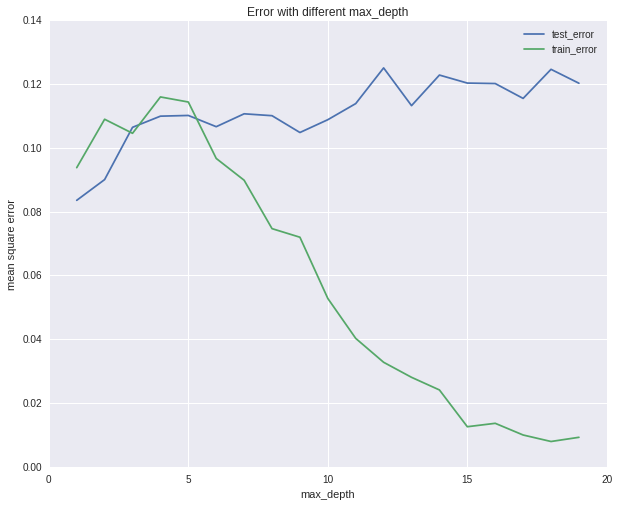

In [449]:
plt.plot(range(1,20),error_test)
plt.plot(range(1,20),error_train)
plt.legend(['test_error','train_error'])
plt.title('Error with different max_depth')
plt.xlabel('max_depth')
plt.ylabel('mean square error')

n_estimators

In [450]:
error_train=[]
error_test=[]
for i in range(1,40):
    error_test.append(evaluate_random_forest_model(X_train,X_test,y_train,y_test,n_estimators=i))
    error_train.append(evaluate_random_forest_model(X_train,X_train,y_train,y_train,n_estimators=i))


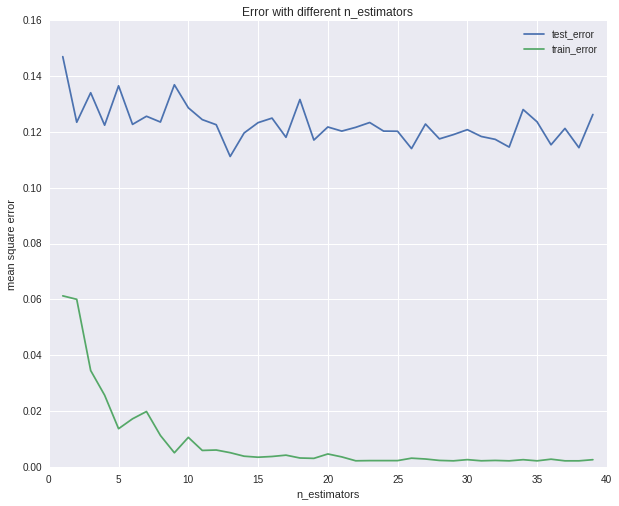

In [451]:
plt.plot(range(1,40),error_test)
plt.plot(range(1,40),error_train)
plt.legend(['test_error','train_error'])
plt.title('Error with different n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('mean square error')

criterion

In [303]:
error_train=[]
error_test=[]

error_test.append(evaluate_random_forest_model(X_train,X_test,y_train,y_test,criterion='gini'))
error_train.append(evaluate_random_forest_model(X_train,X_train,y_train,y_train,criterion='gini'))

error_test.append(evaluate_random_forest_model(X_train,X_test,y_train,y_test,criterion='entropy'))
error_train.append(evaluate_random_forest_model(X_train,X_train,y_train,y_train,criterion='entropy'))

In [304]:
error_train

[0.005208333333333333, 0.0053562039957939008]

In [305]:
error_test

[0.1245563880126183, 0.12906644321766561]

### Cross validation

In [452]:
kf = KFold(train_trivial.shape[0], n_folds=30, shuffle=True)

In [453]:
def cross_val(database,output,n_estimators=10,criterion='gini',
                                max_depth=None):
    error_train=[]
    error_test=[]
    for iteration, data in enumerate(kf, start=1):
        X_train=database.iloc[data[0]]
        X_test=database.iloc[data[1]]
        y_train=output.iloc[data[0]]
        y_test=output.iloc[data[1]]

        error_test.append(evaluate_random_forest_model(X_train,X_test,y_train,y_test,
                                                       n_estimators=n_estimators,criterion=criterion,
                                                       max_depth=max_depth))
        error_train.append(evaluate_random_forest_model(X_train,X_train,y_train,y_train,
                                                        n_estimators=n_estimators,criterion=criterion,
                                                       max_depth=max_depth))
    return np.mean(error_train),np.mean(error_test)


max_depth

In [454]:
error_train=[]
error_test=[]
for i in range(1,40):
    error_train_,error_test_=cross_val(train_trivial,y_trivial,max_depth=i)
    error_train.append(error_train_)
    error_test.append(error_test_)


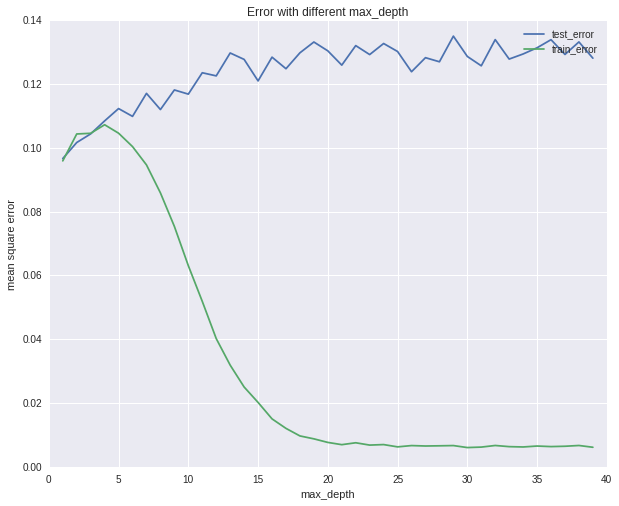

In [455]:
plt.plot(range(1,40),error_test)
plt.plot(range(1,40),error_train)
plt.legend(['test_error','train_error'])
plt.title('Error with different max_depth')
plt.xlabel('max_depth')
plt.ylabel('mean square error')

n_estimators

In [456]:
error_train=[]
error_test=[]
for i in range(1,40):
    error_train_,error_test_=cross_val(train_trivial,y_trivial,n_estimators=i)
    error_train.append(error_train_)
    error_test.append(error_test_)


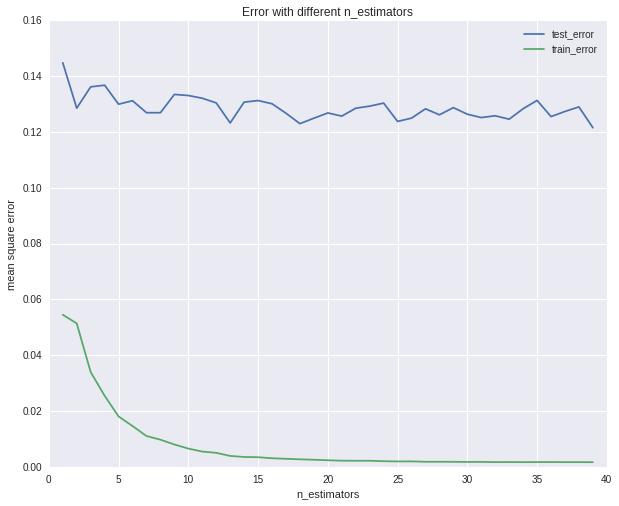

In [457]:
plt.plot(range(1,40),error_test)
plt.plot(range(1,40),error_train)
plt.legend(['test_error','train_error'])
plt.title('Error with different n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('mean square error')

criterion

In [458]:
error_train=[]
error_test=[]

error_train_,error_test_=cross_val(train_trivial,y_trivial,criterion='gini')

error_train.append(error_train_)
error_test.append(error_test_)

error_train_,error_test_=cross_val(train_trivial,y_trivial,criterion='entropy')

error_train.append(error_train_)
error_test.append(error_test_)

In [459]:
error_train

[0.0067639538845003762, 0.0063223574045782457]

In [460]:
error_test

[0.1310574277334301, 0.12841244103773583]